
# General Information about sabot separation
## 3 possible outcomes of a test:
### Sabot doesn’t separate enough and travels to target tank 
* Failure Mode I
* Too small of pressure for given velocity and sabot size
### Excessive aerodynamic forces break up the sabot
* Failure Mode II
* Too large of pressure for given velocity and sabot size
### Sabot separates cleanly and projectile continues to target tank
* Goldilocks pressure range


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


In [38]:
# Import collected and failed data

def read_csv_to_dataframe(file_path):
    df = pd.read_csv(file_path)
    column_labels = df.columns.tolist()
    df.columns = column_labels
    return df


collectedData = read_csv_to_dataframe('collected_data.csv')
failedData = read_csv_to_dataframe('failed_data.csv')

## 3 corresponding types of data
### Successful tests (collectedData):
* Have input variables
* Have measured DoS
### Failed tests (failedData):
* Have input variables
* No measured DoS but do have failure mode
### Synthetic data point (syntheticData):
* Known from aerodynamic/natural laws
* If pressure = 0, no degree of separation



In [39]:
# Generate synthetic data

numData = len(collectedData) + len(failedData)
maxVelocity = max(collectedData['Velocity'].max(), failedData['Velocity'].max())
minVelocity = min(collectedData['Velocity'].min(), failedData['Velocity'].min())

# number of synthetic data points is arbitrarily set at 1/10 of total data points, then equally spaced throughout velocity regime
numSyntheticData = round(numData / 10)
syntheticVelocities = np.linspace(minVelocity, maxVelocity, numSyntheticData)

# generate data frame
numRows = numSyntheticData
syntheticData = pd.DataFrame({
    # degree is 0 because at any velocity and 0 pressure, degree is 0.
    'Degree': np.zeros(numRows),
    'Velocity': syntheticVelocities,
    'Pressure': np.zeros(numRows),
    # sabot type (4 or 10 mm) is generated randomly
    'Sabot': np.random.choice([0, 1], numRows)
})

# join all datapoints into one df and randomize order
combinedData = pd.DataFrame(columns=['Degree', 'Velocity', 'Pressure', 'Sabot'])
combinedData = pd.concat([combinedData, collectedData, failedData, syntheticData], ignore_index=True)
combinedData = combinedData.drop('Comments', axis=1)

# Randomize the order of rows
combinedData = combinedData.sample(frac=1).reset_index(drop=True)

In [46]:
# Split the data into train/test
from sklearn.model_selection import train_test_split
X = combinedData.drop('Degree', axis=1)
y = combinedData['Degree']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [71]:
from sklearn.preprocessing import StandardScaler

# optional scaling
sc = StandardScaler()
X_collected_scaled = sc.fit_transform(collectedData.drop('Degree', axis=1))
X_scaled = sc.fit_transform(X)
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)


In [74]:
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(random_state=0)
X_pca = pca.fit_transform(X_collected_scaled)
print(X_pca.shape)
varExplained = pca.explained_variance_ratio_ * 100

# plot
for column_index in range(X_pca.shape[1]):
    
    reshaped_column = X_pca[:, column_index]

    # Set the y-label and x-label for the plot
    y_label = 'weight'
    x_label = 'Principal component: ' + str(column_index)

    # Create the plot using seaborn
    sns.scatterplot(x=reshaped_column, y=Y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Graph of Column ' + str(column_index))
    plt.show()

(55, 3)
0


ValueError: array length 55 does not match index length 74

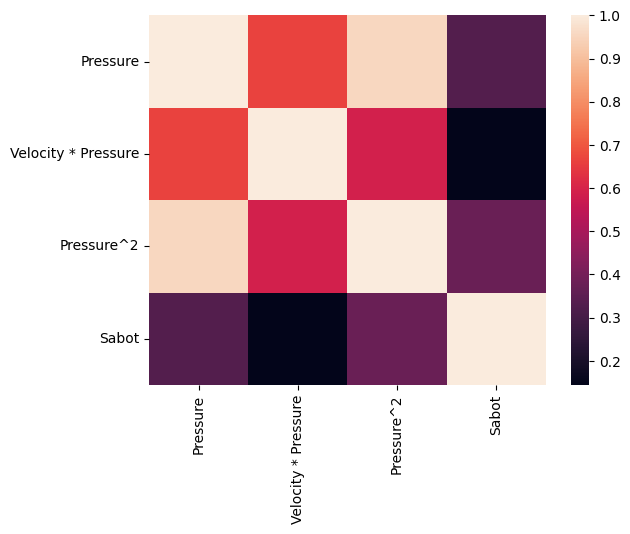

In [51]:



X_previous = pd.DataFrame()

# Copy 'Pressure' column to the new DataFrame
X_previous['Pressure'] = X['Pressure']

# Calculate 'Velocity * Pressure' column
X_previous['Velocity * Pressure'] = X['Velocity'] * X['Pressure']

# Calculate 'Pressure^2' column
X_previous['Pressure^2'] = X['Pressure'] ** 2

# Copy 'Sabot' column to the new DataFrame
X_previous['Sabot'] = X['Sabot']

# create a covariance matrix
X_previous_mean = X_previous.mean()
X_previous_std = X_previous.std()
Z_previous = (X_previous - X_previous_mean) / X_previous_std
c = Z_previous.cov()

# Plot the covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(c)
plt.show()



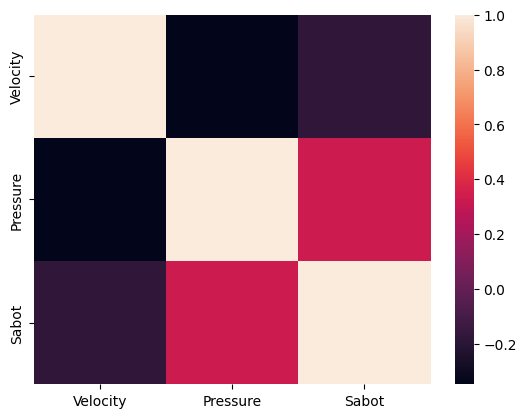

In [49]:
# create a covariance matrix
X_mean = X.mean()
X_std = X.std()
Z = (X - X_mean) / X_std
c = Z.cov()

# Plot the covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(c)
plt.show()


In [42]:
# Regression
V = collectedData['Velocity']
P = collectedData['Pressure']
S = collectedData['Sabot']
D = collectedData['Degree']


def regression(V, P, S, D):
   
    S_poly = np.zeros((len(collectedData), 10))
    S_poly[:, 0] = np.ones(1)
    S_poly[:, 1] = V*1
    S_poly[:, 2] = V*V*1
    S_poly[:, 3] = P*1
    S_poly[:, 4] = P*P*1
    S_poly[:, 5] = S*1
    S_poly[:, 6] = S*S*1
    S_poly[:, 7] = V*P*1
    S_poly[:, 8] = V*S*1
    S_poly[:, 9] = P*S*1
    S_opt = S_poly[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]]
    regressor_OLS = sm.OLS(endog = D, exog = S_opt).fit()
    print(regressor_OLS.summary())
    
regression(V, P, S, D)



                            OLS Regression Results                            
Dep. Variable:                 Degree   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     62.68
Date:                Thu, 11 May 2023   Prob (F-statistic):           1.10e-21
Time:                        16:32:50   Log-Likelihood:                -130.30
No. Observations:                  55   AIC:                             276.6
Df Residuals:                      47   BIC:                             292.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.0091     16.673     -0.960      0.3